### Your name:

<pre> Marco Stevanella</pre>

### Collaborators:

<pre> Enter the name of the people you worked with if any</pre>


# Assignment for Module 4: Clustering

## Description

In this assignment you will study the electric demand (power) of clients in Portugal, during 2013 and 2014.

The data$^1$ available contains 370 time series, corresponding to the electric demand$^2$ for 370 clients, between 2011 and 2014. 

In this guided exercise you will use clustering techniques to understand the typical behaviour during 2013-2014.

#### 1. Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

#### 2. Electric Demand:
http://www.think-energy.net/KWvsKWH.htm


## Data Preparation

Start by downloading the data to a local directory and modify the "pathToFile" and "fileName" variables, if needed

In [ ]:
pathToFile = r"C:\Users\admin\OneDrive\Documents\ML\DATASETS"
fileName = "LD2011_2014.txt"

In [8]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

In [11]:
# Replace "," by ".", otherwise the numbers will be in the form 2,3445 instead of 2.3445
import fileinput
import os

fullPath = os.path.join(pathToFile, fileName)

with fileinput.FileInput(fullPath, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(",", "."), end='')

In [ ]:
# Create dataframe
import pandas as pd
data = pd.read_csv(fullPath, sep=";", index_col=0)

### Quick data inspection

In [14]:
data.head(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
data.tail(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.17524,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541
2015-01-01 00:00:00,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.17524,249.158249,62.937063,69.892473,...,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7135.135135


In [16]:
data.shape

(140256, 370)

#### As can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0+ MB


In [20]:
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,...,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,...,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.844950,0.000000,36.585366,15.853659,71.428571,0.565291,111.111111,13.986014,9.677419,...,5.710207,0.000000,0.000000,0.000000,13.037810,0.000000,0.000000,30.050083,83.944282,0.000000
50%,1.269036,24.893314,1.737619,87.398374,39.024390,157.738095,2.826456,222.222222,40.209790,40.860215,...,131.334761,24100.000000,1050.632911,2136.363636,31.290743,7.021650,525.899912,76.794658,758.064516,0.000000
75%,2.538071,29.871977,1.737619,115.853659,54.878049,205.357143,4.522329,279.461279,57.692308,61.290323,...,403.283369,54800.000000,3312.236287,5363.636364,108.213820,11.702750,627.743635,151.919866,875.366569,17783.783784
max,48.223350,115.220484,151.172893,321.138211,150.000000,535.714286,44.657999,552.188552,157.342657,198.924731,...,852.962170,192800.000000,7751.054852,12386.363636,335.071708,60.269163,1138.718174,362.270451,1549.120235,30918.918919


### Plot the 2 days of 2012 for the first 2 clients

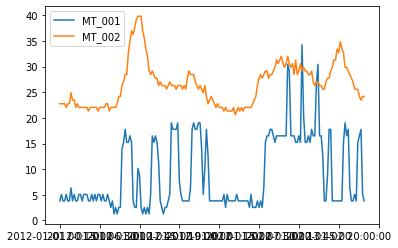

In [21]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

#### We quickly note that the main difference between the curves is the level (also seen on the means in df.describe()), so we know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day, rather than the overall level.

### Data for the analysis

We focus on 2013 and 2014 because these are the years with lower number of clients having zero demand

In [22]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [23]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [24]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [25]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand
data_13_14 = data2013.append(data2014) # appending 2013 and 2014
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # drop clients with 0 demand
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

C:\Users\admin\AppData\Local\Temp\ipykernel_8900\2042128106.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_13_14 = data2013.append(data2014) # appending 2013 and 2014


(70080, 349)
0


## Getting average curves per client

In [26]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [27]:
data['hour'] = data.index.map(lambda x: x[11:])

In [28]:
data.head(3)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,hour
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,...,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486,00:15:00
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,...,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486,00:30:00
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,...,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649,00:45:00


### Getting average curves per client

In [29]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 

(96, 349)

#### The dataframe average_curves contains the 349 typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1

In [30]:
average_curves_norm = average_curves/(average_curves.mean())

#### Plot the first 2 and last 2 clients

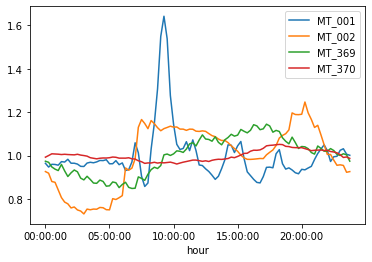

In [31]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

## Clustering Analysis on the average normizalied curves

In [32]:
X = average_curves_norm.copy()
X = np.array(X.T) # put it on the right format

In [33]:
X

array([[0.96479215, 0.94737834, 0.96010381, ..., 1.03176835, 1.00665227,
        1.00162906],
       [0.92667365, 0.91911689, 0.8807438 , ..., 0.95492484, 0.9233459 ,
        0.92656966],
       [0.99179969, 0.97779638, 0.9765787 , ..., 1.00397648, 0.99849693,
        0.99301737],
       ...,
       [1.17044059, 1.22381837, 1.21134255, ..., 1.17431116, 1.15378816,
        1.13637963],
       [0.97430716, 0.96926554, 0.94796904, ..., 1.00867049, 1.00368029,
        0.97461078],
       [0.99296729, 1.00054813, 1.00851498, ..., 0.99165659, 0.99394714,
        0.98743097]])

## Exercise 1:

a. Using the functions described in Module 2, determine what a convenient number of clusters based on _intertia_ and based on _silhouette_. Justify your choice



In [34]:
def getInertia(X,kmeans):
    ''' This function returns the exact same value as the attribute inertia_ of kmeans'''
    inertia = 0
    for J in range(len(X)):
        inertia = inertia + np.linalg.norm(X[J] - kmeans.cluster_centers_[kmeans.labels_[J]])**2
    return inertia

In [35]:
def getInertia2(X,kmeans):
    ''' This function is analogous to getInertia, but with respect to the 2nd closest center, rather than closest one'''
    inertia2 = 0
    for J in range(len(X)):
        L = min(1,len(kmeans.cluster_centers_)-1) # this is just for the case where there is only 1 cluster at all
        dist_to_center = sorted([np.linalg.norm(X[J] - z)**2 for z in kmeans.cluster_centers_])[L]
        inertia2 = inertia2 + dist_to_center
    return inertia2 

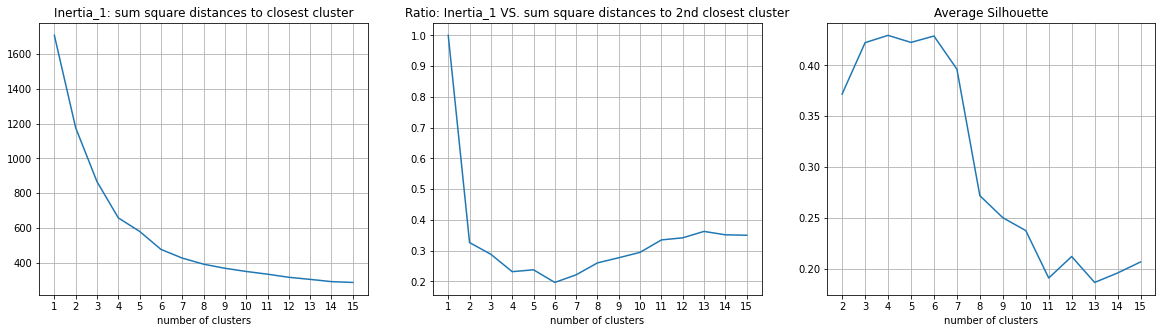

In [36]:
inertias_1 = []
inertias_2 = []
silhouette_avgs = []
max_K = 15
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)    
    inertias_1 = inertias_1 + [kmeans.inertia_]
    inertias_2 = inertias_2 + [getInertia2(X,kmeans)]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title("Inertia_1: sum square distances to closest cluster")
plt.plot(np.arange(1,max_K+1),inertias_1)
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()
    
plt.subplot(1,3,2)    
plt.title("Ratio: Inertia_1 VS. sum square distances to 2nd closest cluster")
plt.plot(np.arange(1,max_K+1),np.array(inertias_1)/np.array(inertias_2))
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.subplot(1,3,3)  
plt.title("Average Silhouette")
plt.plot(np.arange(2,max_K+1), silhouette_avgs)
plt.xticks(np.arange(2,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.show()

After analyzing the following graphs, we can clearly see that the total number of clusters as 6 should be the most convenient choice.

Let's verify why a cluster of 6 have been chosen.

b. Make a plot for each cluster, that includes:
    - The number of clients in the cluster (you can put this in the title of the plot)
    - All the curves in the cluster
    - The curve corresponding to the centroid of the cluster (make this curve thicker to distinguish it from the individual curves)
    
You can do 2 separate plots for each cluster if you prefer (one for the individual curves, one for the centroid)

In [38]:
trueK = 6

kmeans = KMeans(n_clusters=trueK, random_state=0).fit(X)

centroids = kmeans.cluster_centers_

centroids = centroids / np.mean(centroids) # Divide each centroid by its average

centroids.shape

(6, 96)

In [39]:
kmeans_labels = kmeans.labels_ # Extract all the clusters for all 349 clients

Label_DF = pd.DataFrame(kmeans_labels)

keys = [i for i in range(kmeans_labels.shape[0])] #Create a Client identifier from 0 to 349

# Create a dictiory with keys between 0 and 348.

TR_Dictionary = dict(zip(keys, X))

# Create the Master Data Frame

Label_DF['Client'] = pd.Series(keys, index=Label_DF.index) # Merge the Clients and Cluster in the Data Frame

Label_DF.columns =['Cluster','Client']

Label_DF.groupby('Cluster')['Client'].count()

Sorted_Label_DF = Label_DF.sort_values(by=['Cluster'], ascending = True) # Sort all the clusters

In [42]:
import numpy as np

# Filter all the dataframes and assign them the target matrices
Target_0 = Label_DF[Label_DF.Cluster == 0]
Target_Mat_0 = Target_0['Client'].values  # Use .values or .to_numpy()
Target_X_0 = np.array([TR_Dictionary[i] for i in Target_Mat_0])

Target_1 = Label_DF[Label_DF.Cluster == 1]
Target_Mat_1 = Target_1['Client'].values
Target_X_1 = np.array([TR_Dictionary[i] for i in Target_Mat_1])

Target_2 = Label_DF[Label_DF.Cluster == 2]
Target_Mat_2 = Target_2['Client'].values
Target_X_2 = np.array([TR_Dictionary[i] for i in Target_Mat_2])

Target_3 = Label_DF[Label_DF.Cluster == 3]
Target_Mat_3 = Target_3['Client'].values
Target_X_3 = np.array([TR_Dictionary[i] for i in Target_Mat_3])

Target_4 = Label_DF[Label_DF.Cluster == 4]
Target_Mat_4 = Target_4['Client'].values
Target_X_4 = np.array([TR_Dictionary[i] for i in Target_Mat_4])

Target_5 = Label_DF[Label_DF.Cluster == 5]
Target_Mat_5 = Target_5['Client'].values
Target_X_5 = np.array([TR_Dictionary[i] for i in Target_Mat_5])


In [43]:
#####APPLY COSMETICS FORMATTING FOR THE GRAPHS###########

import datetime

now = datetime.datetime(2013, 2, 9, 0, 00)
end=now+datetime.timedelta(hours=23.75)

l=[]
while now<=end:
    l.append(now)
    now+=datetime.timedelta(minutes=15)

x_axis_time = [t.strftime("%H:%M") for t in l]
x_axis_time = np.array(x_axis_time)
x_axis_time = x_axis_time.reshape([-1, 1])

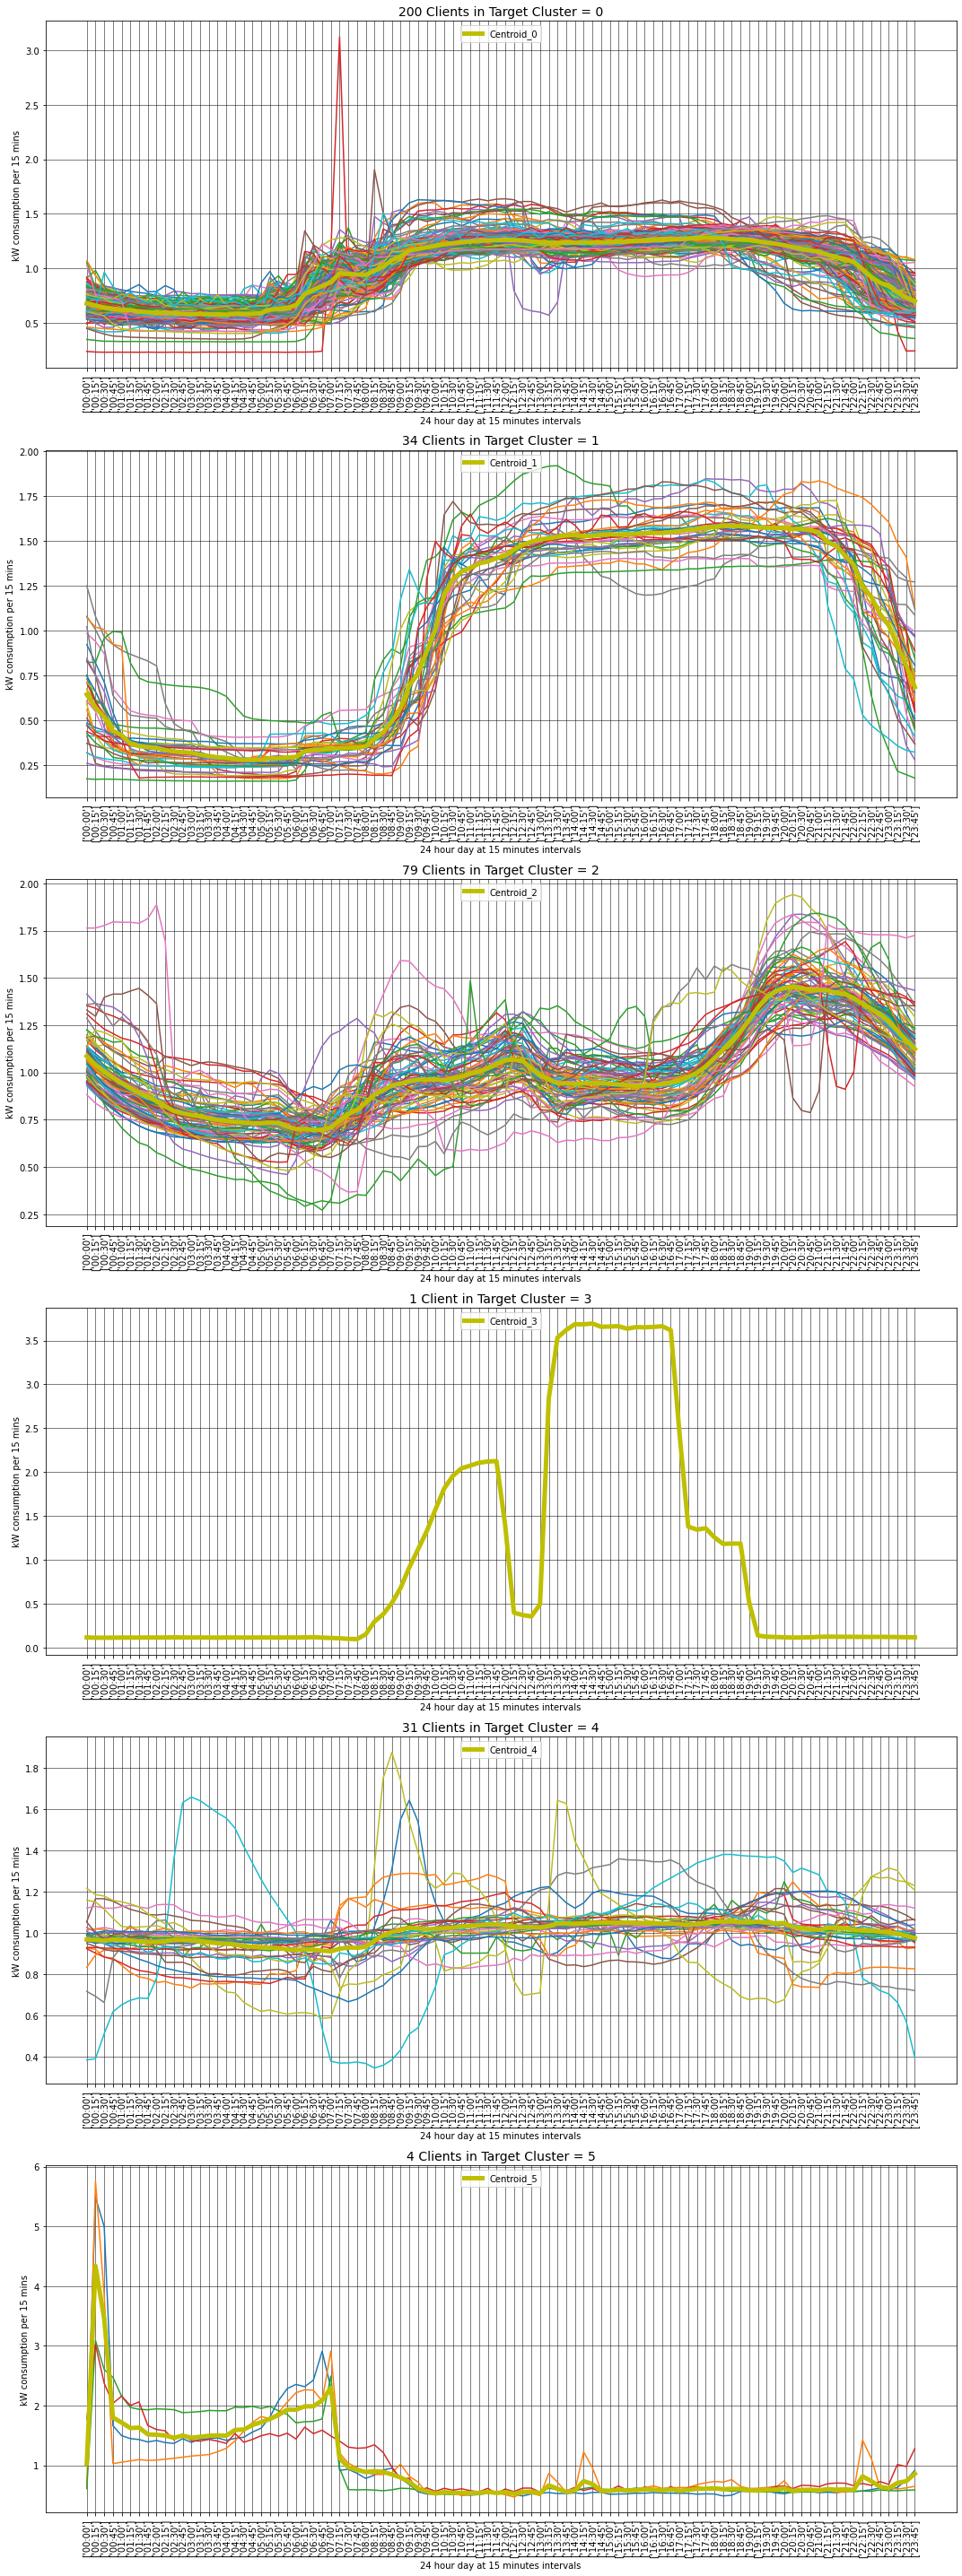

In [44]:
# Time to graph

# plt.figure(figsize=(100,4))
plt.figure(figsize=(15,40))

x_axis = [i for i in range(96)]

plt.plot()

plt.subplot(6,1,1)
#plt.subplot(161)
plt.title("200 Clients in Target Cluster = 0", fontsize=14)
for i in range(Target_X_0.shape[0]):
    plt.plot(Target_X_0[i])
plt.plot(centroids[0], linewidth = 5, c = 'y', label = "Centroid_0")
plt.xticks(x_axis, list(x_axis_time), rotation='vertical') # DO NOT DELETE
plt.xlabel("24 hour day at 15 minutes intervals")
plt.ylabel("kW consumption per 15 mins")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.legend(loc="upper center")

plt.subplot(6,1,2)
#plt.subplot(162)
plt.title("34 Clients in Target Cluster = 1", fontsize=14)
for i in range(Target_X_1.shape[0]):
    plt.plot(Target_X_1[i])
plt.plot(centroids[1], linewidth = 5, c = 'y', label = "Centroid_1")
plt.xticks(x_axis, list(x_axis_time), rotation='vertical')
plt.xlabel("24 hour day at 15 minutes intervals")
plt.ylabel("kW consumption per 15 mins")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.legend(loc="upper center")

plt.subplot(6,1,3)
#plt.subplot(163)
plt.title("79 Clients in Target Cluster = 2", fontsize=14)
for i in range(Target_X_2.shape[0]):
    plt.plot(Target_X_2[i])
plt.plot(centroids[2], linewidth = 5, c = 'y', label = "Centroid_2")
plt.xticks(x_axis, list(x_axis_time), rotation='vertical')
plt.xlabel("24 hour day at 15 minutes intervals")
plt.ylabel("kW consumption per 15 mins")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.legend(loc="upper center")

plt.subplot(6,1,4)
#plt.subplot(164)
plt.title("1 Client in Target Cluster = 3", fontsize=14)
for i in range(Target_X_3.shape[0]):
    plt.plot(Target_X_3[i])
plt.plot(centroids[3], linewidth = 5, c = 'y', label = "Centroid_3")
plt.xticks(x_axis, list(x_axis_time), rotation='vertical')
plt.xlabel("24 hour day at 15 minutes intervals")
plt.ylabel("kW consumption per 15 mins")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.legend(loc="upper center")

plt.subplot(6,1,5)
#plt.subplot(165)
plt.title("31 Clients in Target Cluster = 4", fontsize=14)
for i in range(Target_X_4.shape[0]):
    plt.plot(Target_X_4[i])
plt.plot(centroids[4], linewidth = 5, c = 'y', label = "Centroid_4")
plt.xticks(x_axis, list(x_axis_time), rotation='vertical')
plt.xlabel("24 hour day at 15 minutes intervals")
plt.ylabel("kW consumption per 15 mins")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.legend(loc="upper center")

plt.subplot(6,1,6)
#plt.subplot(166)
plt.title("4 Clients in Target Cluster = 5", fontsize=14)
for i in range(Target_X_5.shape[0]):
    plt.plot(Target_X_5[i])
plt.plot(centroids[5], linewidth = 5, c = 'y', label = "Centroid_5")
plt.xticks(x_axis, list(x_axis_time), rotation='vertical')
plt.xlabel("24 hour day at 15 minutes intervals")
plt.ylabel("kW consumption per 15 mins")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.legend(loc="upper center")

plt.show()

## Exercises 2

In this exercise you work with the daily curves of 1 single client.

First you create a list of arrays, each array containing a normalized curve for a day. The list contains 730 arrays, one for each of the days of 2013 and 2014.

a. Determine the optimal value for k-means. 

b. What are the clusters that you obtained represent?

In [415]:
client = 'MT_022'
oneClient = data_13_14[client]
X = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])]) 

In [45]:
# 2.a Determine the optimal value for k-means ###

# Run inertia, inertia2, silhouette

def getInertia(X,kmeans):
    ''' This function returns the exact same value as the attribute inertia_ of kmeans'''
    inertia = 0
    for J in range(len(X)):
        inertia = inertia + np.linalg.norm(X[J] - kmeans.cluster_centers_[kmeans.labels_[J]])**2
    return inertia

# Inertia 2

def getInertia2(X,kmeans):
    ''' This function is analogous to getInertia, but with respect to the 2nd closest center, rather than closest one'''
    inertia2 = 0
    for J in range(len(X)):
        L = min(1,len(kmeans.cluster_centers_)-1) # this is just for the case where there is only 1 cluster at all
        dist_to_center = sorted([np.linalg.norm(X[J] - z)**2 for z in kmeans.cluster_centers_])[L]
        inertia2 = inertia2 + dist_to_center
    return inertia2   

# Computing 3 performance measures for a range of values of  k

inertias_1 = []
inertias_2 = []
silhouette_avgs = []
max_K = 15
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)    
    inertias_1 = inertias_1 + [kmeans.inertia_]
    inertias_2 = inertias_2 + [getInertia2(X,kmeans)]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]

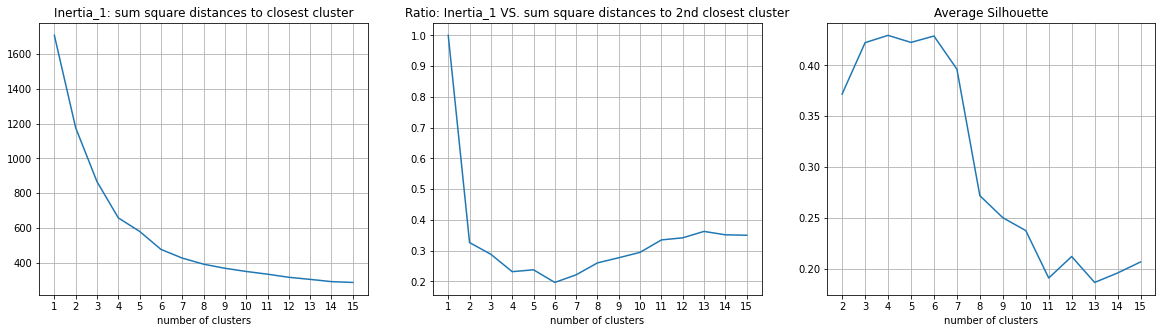

In [46]:
# Plot the inertia, inertia2, silhouette

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title("Inertia_1: sum square distances to closest cluster")
plt.plot(np.arange(1,max_K+1),inertias_1)
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()
    
plt.subplot(1,3,2)    
plt.title("Ratio: Inertia_1 VS. sum square distances to 2nd closest cluster")
plt.plot(np.arange(1,max_K+1),np.array(inertias_1)/np.array(inertias_2))
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.subplot(1,3,3)  
plt.title("Average Silhouette")
plt.plot(np.arange(2,max_K+1), silhouette_avgs)
plt.xticks(np.arange(2,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.show()

In [47]:
K_true_new = 2

kmeans = KMeans(n_clusters=K_true_new, random_state=0).fit(X)

centroids = kmeans.cluster_centers_

centroids = centroids / np.mean(centroids) # Divide each centroid by its average

centroids.shape

### b. What are the clusters that you obtained represent? ###

kmeans_labels = kmeans.labels_ 

Label_DF = pd.DataFrame(kmeans_labels)

keys = [i for i in range(kmeans_labels.shape[0])] #Create the key identifier between 0 and 729

# Create a dictionary with keys

TR_Dictionary = dict(zip(keys, X)) 

Label_DF['Data'] = pd.Series(keys, index=Label_DF.index) # Merge the actual data and Cluster in the Data Frame

Label_DF.columns =['Cluster','Data']

Label_DF.groupby('Cluster')['Data'].count()

Sorted_Label_DF = Label_DF.sort_values(by=['Cluster'], ascending = True) # Sort all the clusters

In [49]:
Target_0 = Label_DF[Label_DF.Cluster == 0]
Target_Mat_0 = Target_0['Data'].values

Target_X_0 = [TR_Dictionary[i] for i in Target_Mat_0] #Map the dictionary to the Targets
Target_X_0 = np.array(Target_X_0)

Target_1 = Label_DF[Label_DF.Cluster == 1]
Target_Mat_1 = Target_1['Data'].values

Target_X_1 = [TR_Dictionary[i] for i in Target_Mat_1] #Map the dictionary to the Targets
Target_X_1 = np.array(Target_X_1)

In [50]:
#####APPLY COSMETICS FORMATTING FOR THE GRAPHS###########

import datetime

now = datetime.datetime(2013, 2, 9, 0, 00)
end=now+datetime.timedelta(hours=23.75)

l=[]
while now<=end:
    l.append(now)
    now+=datetime.timedelta(minutes=15)

x_axis_time = [t.strftime("%H:%M") for t in l]
x_axis_time = np.array(x_axis_time)
x_axis_time = x_axis_time.reshape([-1, 1])

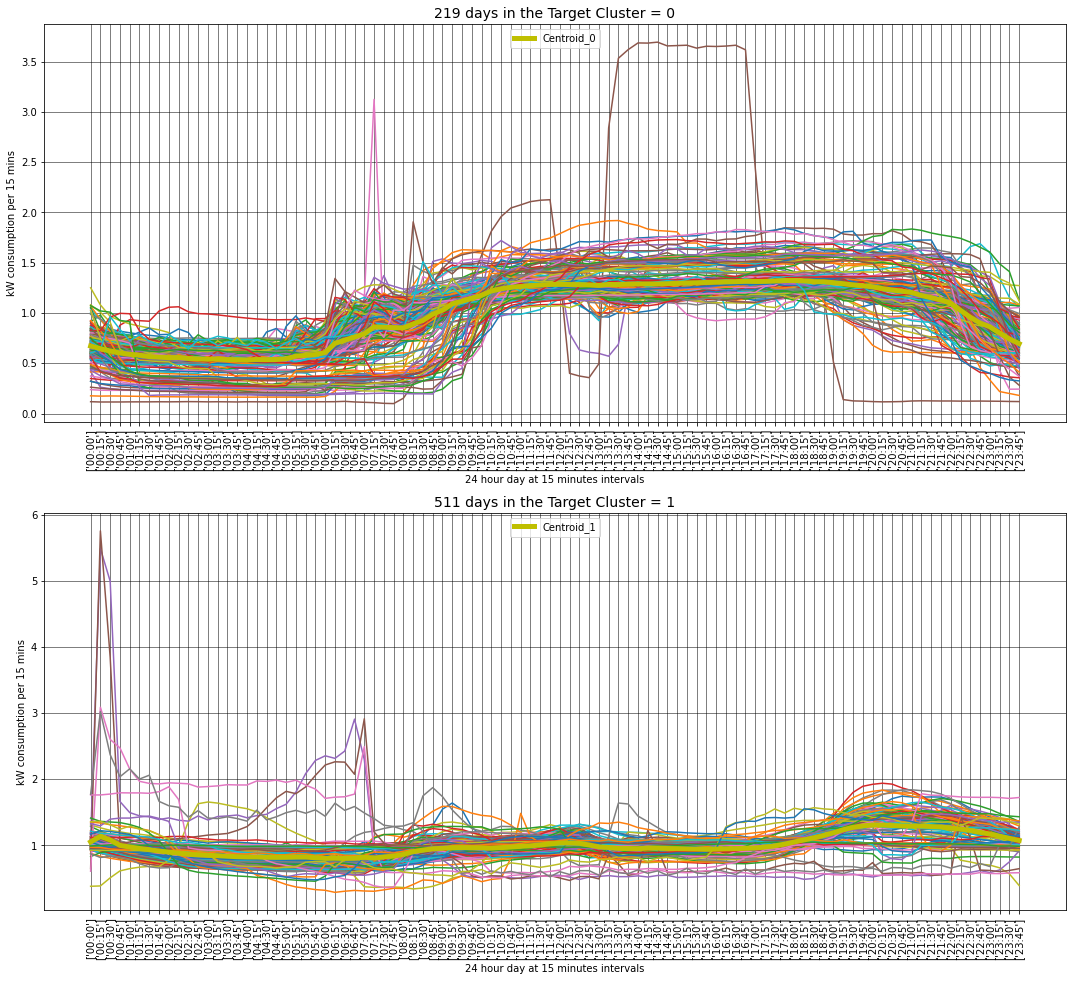

In [51]:
# plt.figure(figsize=(100,4))
plt.figure(figsize=(15,40))

x_axis = [i for i in range(96)]

plt.plot()

plt.subplot(6,1,1)
#plt.subplot(161)
plt.title("219 days in the Target Cluster = 0", fontsize=14)
for i in range(Target_X_0.shape[0]):
    plt.plot(Target_X_0[i])
plt.plot(centroids[0], linewidth = 5, c = 'y', label = "Centroid_0")
plt.xticks(x_axis, list(x_axis_time), rotation='vertical') # DO NOT DELETE
plt.xlabel("24 hour day at 15 minutes intervals")
plt.ylabel("kW consumption per 15 mins")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.legend(loc="upper center")

plt.subplot(6,1,2)
#plt.subplot(162)
plt.title("511 days in the Target Cluster = 1", fontsize=14)
for i in range(Target_X_1.shape[0]):
    plt.plot(Target_X_1[i])
plt.plot(centroids[1], linewidth = 5, c = 'y', label = "Centroid_1")
plt.xticks(x_axis, list(x_axis_time), rotation='vertical')
plt.xlabel("24 hour day at 15 minutes intervals")
plt.ylabel("kW consumption per 15 mins")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.legend(loc="upper center")

plt.show()

Clusters 0 and 1 appear to represent electricity consumption patterns on workdays versus weekends and statutory holidays. However, given that Cluster 0 includes 219 days over a two-year period, it’s unlikely that all of these are weekends. Statutory holidays must also be considered, as they significantly influence usage trends.

For instance, in Portugal, April 25th is celebrated as Freedom Day. In 2014, this date fell on a Friday, meaning electricity usage on that day likely differed from a typical Friday due to the holiday effect.

#### The following cell generates a list of all the days in the two years 2013-2014, which is helpful to answer part (b)

In [52]:
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])

#### The following cell shows you how to do the following: given a list L, and a list of booleans B (True, False), get the sublist of L that corresponds to the True values in B. For example if L=[1,2,3,4] and B=[False,True,True,False], then the results is [2,3]. This is also helpful for pard (b)

In [53]:
from itertools import compress
L = [1,2,3,4]
B = [False, True, True, False]
list(compress(L, B))

[2, 3]